In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, InputLayer
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import warnings
warnings.filterwarnings('ignore')

# Reading the data:

In [3]:
df = pd.read_csv('/kaggle/input/brain-tumor/Brain Tumor.csv')
df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [4]:
import cv2
classes =[]
images= []
path = '/kaggle/input/brain-tumor/Brain Tumor/Brain Tumor/'
files = os.listdir(path)

for i, fle in enumerate(files):
    fileName = fle.split('.')[0]
    status = df[df['Image']== fileName]['Class'].to_numpy()
    classes.append(status)
    total = path + fle
    image= cv2.imread(total)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image= cv2.resize(image,(240,240))
    images.append(image)


In [5]:
images_f=np.array(images)
classes_f=np.array(classes)
images_f.shape

(3762, 240, 240, 3)

The label is: [1]


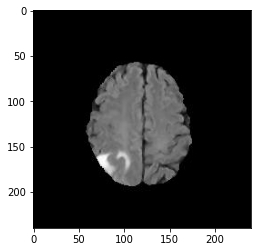

In [6]:
#Viewing a sample image
i = 234
plt.imshow(images_f[i])
print(f'The label is: {classes_f[i]}')

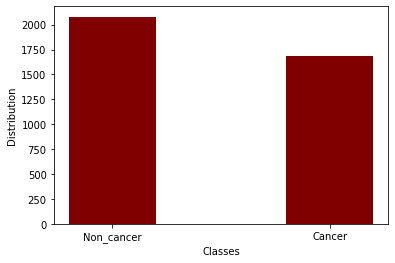

In [7]:
#Inspecting the prior distribution of each class

values, counts = np.unique(classes_f, return_counts=True)
plt.bar(values, counts, color ='maroon',
        width = 0.4)
plt.xticks([0, 1], ['Non_cancer', 'Cancer'])
plt.xlabel('Classes')
plt.ylabel('Distribution')
plt.show()

In [30]:
clss = np.squeeze(classes_f)
threshold = 3650                    # Threshold of data split
ds = pd.DataFrame({                  # Defining dataframe for training and validation
    'file_name': files[:threshold],
    'class': clss[:threshold]
})

dt = pd.DataFrame({                  # Defining dataframe for testing 
    'file_name': files[threshold:],
    'class': clss[threshold:]
})
ds.tail()

,file_name,class
3645,Image2462.jpg,1
3646,Image1731.jpg,0
3647,Image2163.jpg,0
3648,Image2833.jpg,1
3649,Image2094.jpg,0


# Defining Data-loader for our CNN model:

In [9]:
# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = ds,
    directory= path,
    x_col="file_name", 
    y_col="class",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(200,200),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=4,
    )

Found 3640 validated image filenames.


Classes: 1 => Cancer, 0 => Non-Cancer


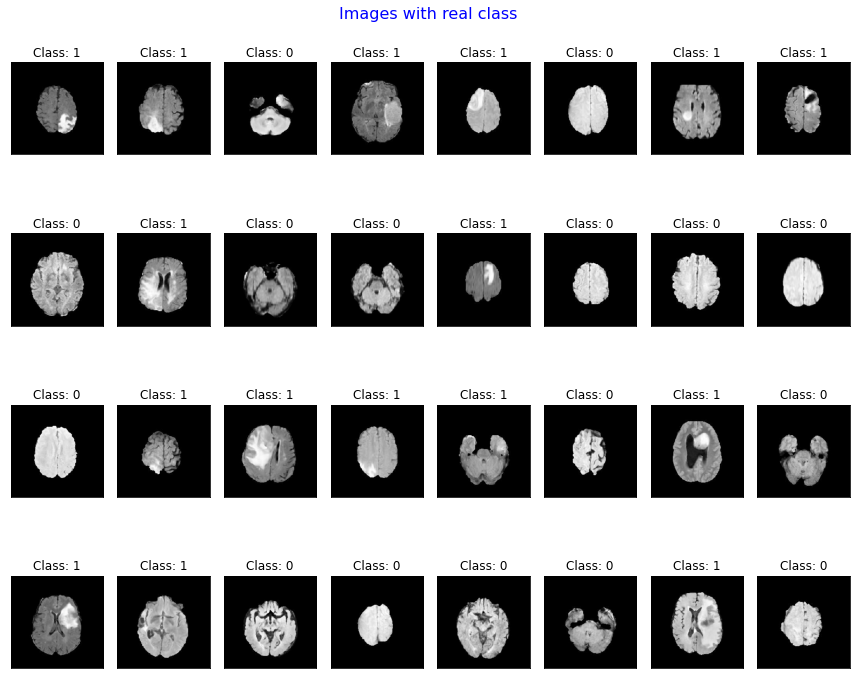

In [10]:
#get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

# display 32 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'Class: {target[i]}')
# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Images with real class',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()
print(f'Classes: 1 => Cancer, 0 => Non-Cancer')

In [11]:
def load_train(path, labels):
    
    """
    It loads the train part of dataset from path
    """
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='class',
        target_size=(240, 240),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow


def load_test(path, labels):
    
    """
    It loads the validation/test part of dataset from path
    """
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path,
    x_col="file_name",
    y_col="class", 
    class_mode="raw", 
    target_size=(240,240), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow


def create_model(input_shape):
    
    """
    It defines the model
    """
    
    model = keras.Sequential()
    model.add(InputLayer(input_shape))
    model.add(Conv2D(filters=128,kernel_size=3, activation="relu", padding="same"))
    model.add(MaxPool2D())
    model.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
    model.add(MaxPool2D())
    model.add(Conv2D(filters=32,kernel_size=3, activation="relu", padding="same"))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
#     model.add(Dense(32, activation="relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(rate=0.1))
    model.add(Dense(1, activation="sigmoid"))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss = BinaryCrossentropy(), metrics=['accuracy'])
    print(model.summary())

    return model


def train_model(model, train_data, test_data, batch_size, epochs=50,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    checkpoint_filepath = 'my_best_model.epoch{epoch:02d}-Accuracy{val_accuracy:.2f}.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only= False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    history = model.fit(train_data, validation_data=test_data, batch_size=batch_size,
              epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks = [model_checkpoint_callback],
              validation_steps=validation_steps, verbose=1)

    return model, history

# CNN Model Creation & Training:

In [12]:
train_data = load_train(path, ds)
test_data = load_test(path, ds)
model = create_model(input_shape = (240, 240, 3))

Found 2730 validated image filenames.
Found 910 validated image filenames.


2022-11-28 17:16:05.202961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 17:16:05.333590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 17:16:05.334390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 17:16:05.336395: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 240, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

In [13]:
def build_model(hp): 
    '''
    In the previous model hyper-parameters were fixed. 
    We need to define the model over some range of hyperparameters to tune it later.
    '''
    model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (240, 240, 3)),
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding="same",
        input_shape=(240, 240, 3)
    ),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding="same"
    ),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding="same"
    ),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [14]:
# Defining keras tuner object
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=8,directory='output',project_name="Brain tumor classification"
                         )

In [15]:
tuner_search.search(images_f[:threshold],classes_f[:threshold],epochs=15,validation_split=0.3)

Trial 8 Complete [00h 01m 23s]
val_accuracy: 0.9139193892478943

Best val_accuracy So Far: 0.9368131756782532
Total elapsed time: 00h 12m 28s


In [16]:
model = tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 240, 96)      2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      27680     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 80)        23120     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 80)        0         
_________________________________________________________________
flatten (Flatten)            (None, 72000)             0

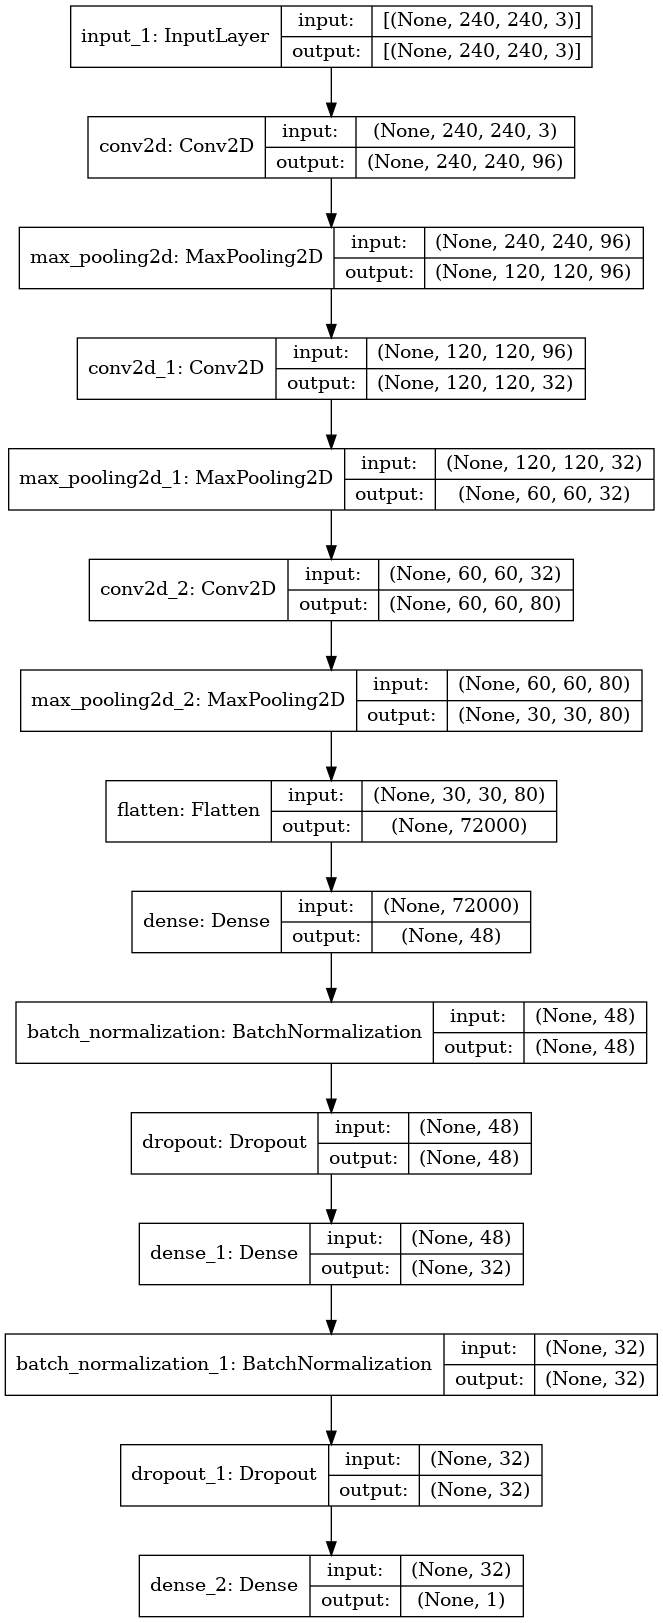

In [17]:
# This shows a pictorial representation of the model
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

In [18]:
model, history = train_model(model, train_data, test_data, 32)

Epoch 1/50
86/86 [==============================] - 10s 110ms/step - loss: 0.2062 - accuracy: 0.9198 - val_loss: 3.3675 - val_accuracy: 0.4330
Epoch 2/50
86/86 [==============================] - 9s 100ms/step - loss: 0.1390 - accuracy: 0.9531 - val_loss: 2.3666 - val_accuracy: 0.4330
Epoch 3/50
86/86 [==============================] - 9s 101ms/step - loss: 0.1193 - accuracy: 0.9597 - val_loss: 2.0495 - val_accuracy: 0.4330
Epoch 4/50
86/86 [==============================] - 9s 101ms/step - loss: 0.1081 - accuracy: 0.9582 - val_loss: 1.6898 - val_accuracy: 0.4330
Epoch 5/50
86/86 [==============================] - 9s 101ms/step - loss: 0.0855 - accuracy: 0.9758 - val_loss: 1.3828 - val_accuracy: 0.4330
Epoch 6/50
86/86 [==============================] - 8s 96ms/step - loss: 0.0649 - accuracy: 0.9788 - val_loss: 1.2587 - val_accuracy: 0.4330
Epoch 7/50
86/86 [==============================] - 9s 102ms/step - loss: 0.0593 - accuracy: 0.9799 - val_loss: 0.6396 - val_accuracy: 0.5648
Epoch 

In [19]:
m = np.max(history.history['val_accuracy'])
i = np.argmax(history.history['val_accuracy'])
print('Maximum validation accuracy: ' + str(m*100) + ' %')
print('after iteration no. ' + str(i+1) +'.')

Maximum validation accuracy: 96.81318402290344 %
after iteration no. 12.


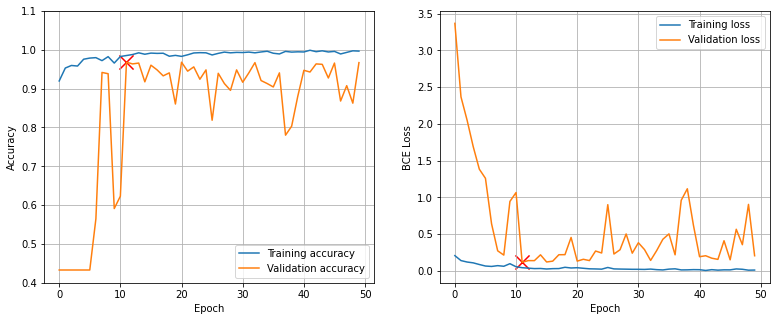

In [29]:
fig, ax =  plt.subplots(1, 2, figsize = (13, 5))
ax[0].plot(history.history['accuracy'], label='Training accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'Validation accuracy')
ax[0].scatter(i, m, marker = 'x', s = 200, c = 'r')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0.4, 1.1])
ax[0].grid(); ax[0].legend(loc='lower right')
plt.legend(loc='lower right')
ax[1].plot(history.history['loss'], label='Training loss')
ax[1].plot(history.history['val_loss'], label = 'Validation loss')
ax[1].scatter(i, history.history['val_loss'][i], marker = 'x', s = 200, c = 'r')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('BCE Loss')
plt.grid()
plt.legend(loc='upper right')
plt.savefig('Accuracy and Loss.png')
plt.show()

In [31]:
# Now we shall test the model with a previously seperated chunk of data
final_test_data = load_test(path, dt)
test_loss, test_acc = model.evaluate(final_test_data, verbose=2)

Found 28 validated image filenames.
1/1 - 0s - loss: 0.0416 - accuracy: 0.9643


In [32]:
print(f'So here we are getting test accuracy of {test_acc*100} %, which is descent for such simple CNN model.')

So here we are getting test accuracy of 96.42857313156128 %, which is descent for such simple CNN model.


In [23]:
%cd /kaggle/working
os.listdir('/kaggle/working')
# from IPython.display import FileLink
# FileLink(r'my_best_model.epoch13-loss0.99.hdf5')
# FileLink(r'Accuracy and Loss.png')


/kaggle/working


['my_best_model.epoch08-Accuracy0.94.hdf5',
 'output',
 'my_best_model.epoch07-Accuracy0.56.hdf5',
 'model.png',
 'Accuracy and Loss.png',
 '__notebook_source__.ipynb',
 '.virtual_documents',
 'my_best_model.epoch01-Accuracy0.43.hdf5',
 'my_best_model.epoch12-Accuracy0.97.hdf5']

# Classification using *Random Forest Classifier* by extracted features form images: 

In [24]:
df1 = df.drop(['Image', 'Class'], axis = 1) # droping image name and label informations from feature set
df1.head()

,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [25]:
from sklearn.preprocessing import StandardScaler

X = df1 
y = df.Class
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Transforming the data to uniform scale for better accuracy


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
pred_rfc = model_rf.predict(X_test)
print(classification_report(y_test, pred_rfc))
acc_rfc = accuracy_score(y_test, pred_rfc)
print(f'Random Forest Classifier has {100*acc_rfc} % accuracy!')

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       419
           1       0.99      0.97      0.98       334

    accuracy                           0.98       753
   macro avg       0.98      0.98      0.98       753
weighted avg       0.98      0.98      0.98       753

Random Forest Classifier has 98.14077025232405 % accuracy!


**So our CNN model performs almost on a par with the inbuilt Random Forest Classifier in terms of test accuracy!**